In [1]:
!bash /home/azureuser/cloudfiles/code/blobfuse/blobfuse_raadsinformatie.sh

In [2]:
import sys
sys.path.append("..")

# Select where to run notebook: "azure" or "local"
my_run = "azure"

# import my_secrets as sc
# import settings as st

if my_run == "azure":
    import config_azure as cf
elif my_run == "local":
    import config as cf


import os
if my_run == "azure":
    if not os.path.exists(cf.HUGGING_CACHE):
        os.mkdir(cf.HUGGING_CACHE)
    os.environ["TRANSFORMERS_CACHE"] = cf.HUGGING_CACHE


import pandas as pd

# set-up environment - GEITje-7b-chat InContextLearning:
# - install blobfuse -> sudo apt-get install blobfuse
# - pip install transformers
# - pip install torch
# - pip install accelerate
# - pip install jupyter
# - pip install ipywidgets

## Notebook Overview
Goal: gain insight into predictions of fewshot experiment

In [3]:
txt = pd.read_pickle(f"{cf.output_path}/txtfiles.pkl")

In [4]:
from transformers import AutoTokenizer
from collections import Counter
from sklearn.metrics import classification_report
import sys
sys.path.append('../src/') 
import prompt_template as pt
import warnings
warnings.simplefilter('ignore')


import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


def get_tokens(model_name, df, text_col, new_col_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    all_texts = list(df[text_col].values)

    all_tokens = []
    all_tokens_len = []
    for txt in all_texts:
        tokens = tokenizer.tokenize(txt)
        all_tokens.append(tokens)
        all_tokens_len.append(len(tokens))

    df[new_col_name] = all_tokens
    df[f"count_{new_col_name}"] = all_tokens_len
    return df

def format_label(label):
    format = f"""{{'categorie': {label}}}"""
    return format
    

def get_response_length(df, model_name):
    # convert response column into tokens, using models tokenizer (so either geitje, mistral or Llama)
    df = get_tokens(model_name, df, 'response', 'responseTokens')

    # convert label into ideal format
    df['label_formatted'] = df['label'].apply(format_label)
    # convert ideal format into tokens, so that we know the ideal length of the responses
    df_ideal = get_tokens(model_name, df.loc[df['run_id']==df.iloc[0]['run_id']], 'label_formatted', 'label_formattedTokens')

    # for each run, describe the response lengths
    description = df.groupby('run_id')['count_responseTokens'].describe()
    description.loc[len(description)] = df_ideal['count_label_formattedTokens'].describe()
    
    print("RESPONSE LENGTH")
    description = description.rename(index={description.index[-1]: 'IDEAL'}).round(1)
    display(description)
    return df
   

def prediction_errors(df):
    print('PREDICTION ERRORS')
    run_ids = sorted(list(set(df['run_id'])))

    error_names = ['NoPredictionInOutput', 'MultiplePredictionErrorInFormatting','NoPredictionFormat', 'MultiplePredictionErrorInOutput']

    # only select row that have prediction error -> response of which a prediction could not be extracted. 
    errors_df = df.loc[df['prediction'].isin(error_names)]

    df_errors_count = pd.DataFrame(columns=error_names)

    for runid in run_ids:
        subdf = errors_df.loc[errors_df['run_id']==runid]
        # count for each error the instances
        count = dict(Counter(subdf['prediction']))

        # check if all errors are included, else set that error to 0
        for error in error_names:
            if error not in count.keys():
                count[error]=0

        df_errors_count.loc[len(df_errors_count)] = count

    df_errors_count.index = run_ids
    df_errors_count['total'] = df_errors_count.sum(axis=1)

    print("Count of prediction errors for each run:")
    display(df_errors_count)

    df_classes_in_response_count = pd.DataFrame(columns=['responses with 0 classes', 'responses with 1 classes', 'responses with 2 classes', 'Correct label in response'])

    for run_id in run_ids:
        subdf = errors_df.loc[errors_df['run_id']==run_id]

        classes_in_responses = []
        correct_class_in_response = []
        for index, row in subdf.iterrows():
            # for each response, return list with all labels that are named in response
            classes_in_response = [category.lower() for category in pt.get_class_list() if category.lower() in row['response'].lower()]
            classes_in_responses.append(classes_in_response)

            # for each response, check if true label is named in response.
            if row['label'].lower() in classes_in_response:
                correct_class_in_response.append(True)
            else:
                correct_class_in_response.append(False)

        # count how many classes are named in a response
        amount_of_classes = dict(Counter([len(response) for response in classes_in_responses]))
        amount_of_classes = {f"responses with {k} classes":v for k,v in amount_of_classes.items()}
        amount_of_classes['Correct label in response'] = f"{correct_class_in_response.count(True)} out of {len(subdf)} prediction errors ({round(correct_class_in_response.count(True)/ len(subdf)*100,1)}%)" 
        df_classes_in_response_count.loc[len(df_classes_in_response_count)] = amount_of_classes

        
    df_classes_in_response_count.index = run_ids

    print('amount of class in responses:')
    display(df_classes_in_response_count)

    # for each run count the errors per class
    count_error_class_df_list = []
    for run_id in run_ids:
        # select errors for current runid
        subdf = errors_df.loc[errors_df['run_id']==run_id]
        errors_count_per_class = dict()
        # for each class count the errors
        for category in pt.get_class_list():
            class_df = subdf.loc[subdf['label']==category.lower()]
            count_errors = dict(Counter(class_df['prediction']))
            # sort the errors from highest to lowest for each class
            count_errors = dict(sorted(count_errors.items(), key=lambda item: item[1], reverse=True))
            errors_count_per_class[category] = count_errors

        # create df
        df_errors_count = pd.DataFrame(list(errors_count_per_class.items()), columns=['Class', run_id])
        # add df to list with the dfs of other runs
        count_error_class_df_list.append(df_errors_count)
    
    # combine df into one
    df_errors_count = count_error_class_df_list[0]
    for count_df in count_error_class_df_list[1:]:
        df_errors_count = df_errors_count.merge(count_df, on='Class', how='outer')
    
    pd.set_option('display.max_colwidth', None)
    print('Amount of errors type per class per run:')
    display(df_errors_count)



def evaluation_metrics(df):
    warnings.filterwarnings("ignore", category=UserWarning)
    report = classification_report(df['label'], df['prediction'])
    print('EVALUATION METRICS')
    print(report)


def percentage_mistakes(count):
    return f"{round(count/1100*100,1)}%"

def mistakes(df, detailed=False):
    print('MISTAKES. INCLUDES PREDICTIONS ERRORS.')
    run_ids = sorted(list(set(df['run_id'])))

    # select all response where the prediction was not correct
    mistakes = df.loc[df['label'] != df['prediction']]

    # groupby run_id so we get the amount of mistakes per run
    mistakes_per_run = mistakes.groupby('run_id').size().reset_index(name='count')
    mistakes_per_run['percentage of total predictions'] = mistakes_per_run['count'].apply(percentage_mistakes)
    print("Total amount of mistakes per run:")
    display(mistakes_per_run)

    # for each run get the amount of mistakes per class
    df_count_class = pd.DataFrame(columns=[category.lower() for category in pt.get_class_list()])
    for run_id in run_ids:
        # select mistakes of current runid
        subdf = mistakes.loc[mistakes['run_id']==run_id]
        # count mistakes per class
        class_count = dict(Counter(subdf['label']))

        # if a class is not included in mistakes, set counter to 0
        for category in pt.get_class_list():
            if category.lower() not in class_count.keys():
                class_count[category.lower()] = 0

        # add count of class to df
        df_count_class.loc[len(df_count_class)] = class_count

    # reset index to runids
    df_count_class.index = run_ids
    print("Amount of mistakes per class for each run:")
    display(df_count_class)

    # For each run get for each class the highest mistakes
    df_highest_class = pd.DataFrame(columns=[category.lower() for category in pt.get_class_list()])
    for run_id in run_ids:
        # select mistakes of current runid
        subdf = mistakes.loc[mistakes['run_id']==run_id]
        # count mistakes of runid
        count_mistakes_per_class = dict(Counter(subdf['label']))

        class_count = subdf.groupby('label')['prediction'].value_counts().reset_index(name='count')
        highest_per_class = dict()
        for label in set(class_count['label']):
            # for each class select the class for which it made the most mistakes
            highest_count_row = class_count.iloc[class_count[class_count['label'] == label]['count'].idxmax()]
            highest_per_class[label] = f"{highest_count_row['prediction']} ({highest_count_row['count']} out of {count_mistakes_per_class[label]})"

        # add to df
        df_highest_class.loc[len(df_highest_class)] = highest_per_class
    # reset index to run_id
    df_highest_class.index = run_ids
    print("Highest mistakes per class for each run:")
    display(df_highest_class.transpose())
   

def runtime(df):
    print("RUNTIME")

    # select all docs that have runtime longer than 75th percentile.
    percentile_75 = df['runtime'].quantile(0.75)

    # count how many docs for each class take longer than 75th percentile
    df_count_long_runtimes = pd.DataFrame(columns=[category.lower() for category in pt.get_class_list()])

    # calculate average runtime per doc for each class
    df_average_runtime = pd.DataFrame(columns=[category.lower() for category in pt.get_class_list()])

    # for each run_id, calculate average runtime and count how many docs exceed 75th percentile
    for run_id in set(df['run_id']):
        subdf = df.loc[df['run_id']==run_id]

        # get very long runtimes
        percentile_75 = subdf['runtime'].quantile(0.75)
        above_75th_percentile = subdf[subdf['runtime'] > percentile_75]
        count_long_runtimes_per_class = dict(Counter(above_75th_percentile['label']))
        df_count_long_runtimes.loc[len(df_count_long_runtimes)] = count_long_runtimes_per_class

        # average runtime per class
        average_runtime_per_class = subdf.groupby('label')['runtime'].mean()
        df_average_runtime.loc[len(df_average_runtime)] = average_runtime_per_class

    df_count_long_runtimes.index = list(set(df['run_id']))
    df_average_runtime.index = list(set(df['run_id']))

    print('Description of runtime per doc:')
    display(df.groupby('run_id')['runtime'].describe().round(1))

    print(f"Amount of docs that took longer than 75th percentile per class:")
    display(df_count_long_runtimes)

    print('Average runtime per doc for each class')
    display(df_average_runtime.transpose().sort_values(by=list(set(df['run_id']))).round(1))


def plot_confusion_matrix(df):
    run_ids = sorted(df['run_id'].unique())

    # Number of plots per row
    plots_per_row = 2

    # Calculate the number of rows needed
    n_rows = (len(run_ids) + plots_per_row - 1) // plots_per_row

    # Create a figure with subplots
    fig, axes = plt.subplots(n_rows, plots_per_row, figsize=(14, 7 * n_rows))

    # Flatten the axes array if there are multiple rows
    if n_rows > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    for i, run_id in enumerate(run_ids):
        subdf = df[df['run_id'] == run_id]
        class_labels = sorted(set(subdf['prediction']).union(set(subdf['label'])))
        class_dict = {label: idx for idx, label in enumerate(class_labels)}

        y_true = np.array([class_dict[label] for label in subdf['label']])
        y_pred = np.array([class_dict[label] for label in subdf['prediction']])

        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_labels)))

        # Plot confusion matrix
        ax = axes[i]
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=class_labels, yticklabels=class_labels, ax=ax)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_title(f'Confusion Matrix for RUN_ID: {run_id}')

    # Hide any remaining empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


/anaconda/envs/2AmsterdamLLM/lib/python3.9/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [8]:
# truncation experiment
predictions =  pd.read_pickle(f"{cf.output_path}/predictionsFinal/in_context/GEITje/zeroshot_prompt_geitje/First200Last0Predictions.pkl")
predictions2 =  pd.read_pickle(f"{cf.output_path}/predictionsFinal/in_context/Mistral/zeroshot_prompt_mistral_llama/First200Last0Predictions.pkl")
predictions3 =  pd.read_pickle(f"{cf.output_path}/predictionsFinal/in_context/Llama/zeroshot_prompt_mistral_llama/First200Last0Predictions.pkl")
zeroshot = pd.concat([predictions, predictions2, predictions3])

predictions =  pd.read_pickle(f"{cf.output_path}/predictionsFinal/in_context/GEITje/fewshot_prompt_no_template/First200Last0Predictions.pkl")
predictions2 =  pd.read_pickle(f"{cf.output_path}/predictionsFinal/in_context/Mistral/fewshot_prompt_with_template/First200Last0Predictions.pkl")
predictions3 =  pd.read_pickle(f"{cf.output_path}/predictionsFinal/in_context/Llama/fewshot_prompt_with_template/First200Last0Predictions.pkl")
fewshot = pd.concat([predictions, predictions2, predictions3])
combined = pd.concat([zeroshot, fewshot])


### Response Length

In [9]:
description = get_response_length(combined, 'meta-llama/Llama-2-7b-chat-hf')

RESPONSE LENGTH


,count,mean,std,min,25%,50%,75%,max
run_id,,,,,,,,
IC_GEITje-7B-chat-v2fewshot_prompt_no_templateLlamaTokens200_0traintest_numEx2,1100.0,17.0,7.5,7.0,15.0,16.0,17.0,211.0
IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens200_0traintest_numEx0,1100.0,16.1,7.3,3.0,15.0,16.0,17.0,227.0
IC_Llama-2-7b-chat-hffewshot_prompt_with_templateLlamaTokens200_0traintest_numEx2,1100.0,160.8,39.3,14.0,134.8,154.0,179.0,256.0
IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,1100.0,90.2,51.1,11.0,51.0,59.5,132.0,256.0
IC_Mistral-7B-Instruct-v0.2fewshot_prompt_with_templateLlamaTokens200_0traintest_numEx2,1100.0,36.0,47.8,9.0,10.0,12.0,42.2,260.0
IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,1100.0,37.7,44.5,9.0,11.0,13.0,58.0,257.0
IDEAL,1100.0,9.1,1.4,7.0,8.0,9.0,10.0,12.0


**Response Length:**
-  GEITje (16.1) closest to ideal (9.1), not bad. 
- Llama: very long responsest, very bad. 
- Mistral: long responses, longer than geitje, shorter than llama.

### Errors

In [13]:
prediction_errors(combined)

PREDICTION ERRORS
Count of prediction errors for each run:


,NoPredictionInOutput,MultiplePredictionErrorInFormatting,NoPredictionFormat,MultiplePredictionErrorInOutput,total
IC_GEITje-7B-chat-v2fewshot_prompt_no_templateLlamaTokens200_0traintest_numEx2,9,27,9,0,45
IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens200_0traintest_numEx0,18,0,62,3,83
IC_Llama-2-7b-chat-hffewshot_prompt_with_templateLlamaTokens200_0traintest_numEx2,24,42,44,0,110
IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,90,0,46,5,141
IC_Mistral-7B-Instruct-v0.2fewshot_prompt_with_templateLlamaTokens200_0traintest_numEx2,12,15,5,14,46
IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,23,8,39,61,131


amount of class in responses:


,responses with 0 classes,responses with 1 classes,responses with 2 classes,Correct label in response
IC_GEITje-7B-chat-v2fewshot_prompt_no_templateLlamaTokens200_0traintest_numEx2,9,28,7,32 out of 45 prediction errors (71.1%)
IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens200_0traintest_numEx0,20,60,3,38 out of 83 prediction errors (45.8%)
IC_Llama-2-7b-chat-hffewshot_prompt_with_templateLlamaTokens200_0traintest_numEx2,28,53,13,67 out of 110 prediction errors (60.9%)
IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,63,59,16,33 out of 141 prediction errors (23.4%)
IC_Mistral-7B-Instruct-v0.2fewshot_prompt_with_templateLlamaTokens200_0traintest_numEx2,11,8,22,13 out of 46 prediction errors (28.3%)
IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,45,13,61,44 out of 131 prediction errors (33.6%)


Amount of errors type per class per run:


,Class,IC_GEITje-7B-chat-v2fewshot_prompt_no_templateLlamaTokens200_0traintest_numEx2,IC_GEITje-7B-chat-v2zeroshot_prompt_geitjeLlamaTokens200_0traintest_numEx0,IC_Llama-2-7b-chat-hffewshot_prompt_with_templateLlamaTokens200_0traintest_numEx2,IC_Llama-2-7b-chat-hfzeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0,IC_Mistral-7B-Instruct-v0.2fewshot_prompt_with_templateLlamaTokens200_0traintest_numEx2,IC_Mistral-7B-Instruct-v0.2zeroshot_prompt_mistral_llamaLlamaTokens200_0traintest_numEx0
0,Actualiteit,{'MultiplePredictionErrorInFormatting': 1},"{'NoPredictionFormat': 5, 'NoPredictionInOutput': 1}","{'NoPredictionFormat': 9, 'NoPredictionInOutput': 5, 'MultiplePredictionErrorInFormatting': 1}","{'NoPredictionInOutput': 10, 'NoPredictionFormat': 4, 'MultiplePredictionErrorInOutput': 1}","{'MultiplePredictionErrorInFormatting': 4, 'NoPredictionInOutput': 1}","{'MultiplePredictionErrorInOutput': 8, 'NoPredictionInOutput': 2}"
1,Agenda,{'NoPredictionInOutput': 1},"{'NoPredictionFormat': 7, 'NoPredictionInOutput': 1}","{'MultiplePredictionErrorInFormatting': 6, 'NoPredictionFormat': 6}",{'NoPredictionInOutput': 10},{'MultiplePredictionErrorInFormatting': 2},{'MultiplePredictionErrorInOutput': 2}
2,Besluit,"{'NoPredictionFormat': 2, 'NoPredictionInOutput': 2, 'MultiplePredictionErrorInFormatting': 1}","{'NoPredictionFormat': 15, 'MultiplePredictionErrorInOutput': 3, 'NoPredictionInOutput': 2}","{'NoPredictionInOutput': 1, 'MultiplePredictionErrorInFormatting': 1, 'NoPredictionFormat': 1}","{'NoPredictionInOutput': 8, 'MultiplePredictionErrorInOutput': 4, 'NoPredictionFormat': 3}","{'NoPredictionInOutput': 1, 'MultiplePredictionErrorInFormatting': 1, 'MultiplePredictionErrorInOutput': 1}","{'MultiplePredictionErrorInOutput': 11, 'MultiplePredictionErrorInFormatting': 1}"
3,Brief,{'MultiplePredictionErrorInFormatting': 1},{'NoPredictionFormat': 1},{'MultiplePredictionErrorInFormatting': 4},"{'NoPredictionFormat': 5, 'NoPredictionInOutput': 3}","{'NoPredictionInOutput': 1, 'MultiplePredictionErrorInFormatting': 1}","{'NoPredictionFormat': 2, 'MultiplePredictionErrorInOutput': 1, 'NoPredictionInOutput': 1}"
4,Factsheet,"{'MultiplePredictionErrorInFormatting': 8, 'NoPredictionFormat': 2, 'NoPredictionInOutput': 2}","{'NoPredictionFormat': 5, 'NoPredictionInOutput': 1}","{'MultiplePredictionErrorInFormatting': 6, 'NoPredictionInOutput': 5, 'NoPredictionFormat': 4}","{'NoPredictionInOutput': 15, 'NoPredictionFormat': 14}","{'MultiplePredictionErrorInOutput': 4, 'NoPredictionFormat': 2, 'MultiplePredictionErrorInFormatting': 1, 'NoPredictionInOutput': 1}","{'NoPredictionFormat': 15, 'NoPredictionInOutput': 9, 'MultiplePredictionErrorInOutput': 3, 'MultiplePredictionErrorInFormatting': 1}"
5,Motie,"{'MultiplePredictionErrorInFormatting': 7, 'NoPredictionFormat': 2}","{'NoPredictionInOutput': 5, 'NoPredictionFormat': 3}","{'NoPredictionInOutput': 2, 'MultiplePredictionErrorInFormatting': 2, 'NoPredictionFormat': 1}","{'NoPredictionFormat': 6, 'NoPredictionInOutput': 2}",{'NoPredictionInOutput': 4},{'MultiplePredictionErrorInFormatting': 1}
6,Onderzoeksrapport,"{'MultiplePredictionErrorInFormatting': 4, 'NoPredictionInOutput': 4}","{'NoPredictionInOutput': 6, 'NoPredictionFormat': 4}","{'NoPredictionFormat': 9, 'MultiplePredictionErrorInFormatting': 7, 'NoPredictionInOutput': 5}","{'NoPredictionInOutput': 26, 'NoPredictionFormat': 5}","{'MultiplePredictionErrorInOutput': 9, 'MultiplePredictionErrorInFormatting': 4, 'NoPredictionInOutput': 4, 'NoPredictionFormat': 2}","{'NoPredictionFormat': 20, 'NoPredictionInOutput': 9, 'MultiplePredictionErrorInFormatting': 2, 'MultiplePredictionErrorInOutput': 1}"
7,Raadsadres,"{'MultiplePredictionErrorInFormatting': 3, 'NoPredictionFormat': 1}","{'NoPredictionFormat': 8, 'NoPredictionInOutput': 1}","{'MultiplePredictionErrorInFormatting': 7, 'NoPredictionFormat': 5, 'NoPredictionInOutput': 4}","{'NoPredictionFormat': 3, 'NoPredictionInOutput': 2}",{},"{'MultiplePredictionErrorInOutput': 6, 'NoPred

### Confusion Matrix

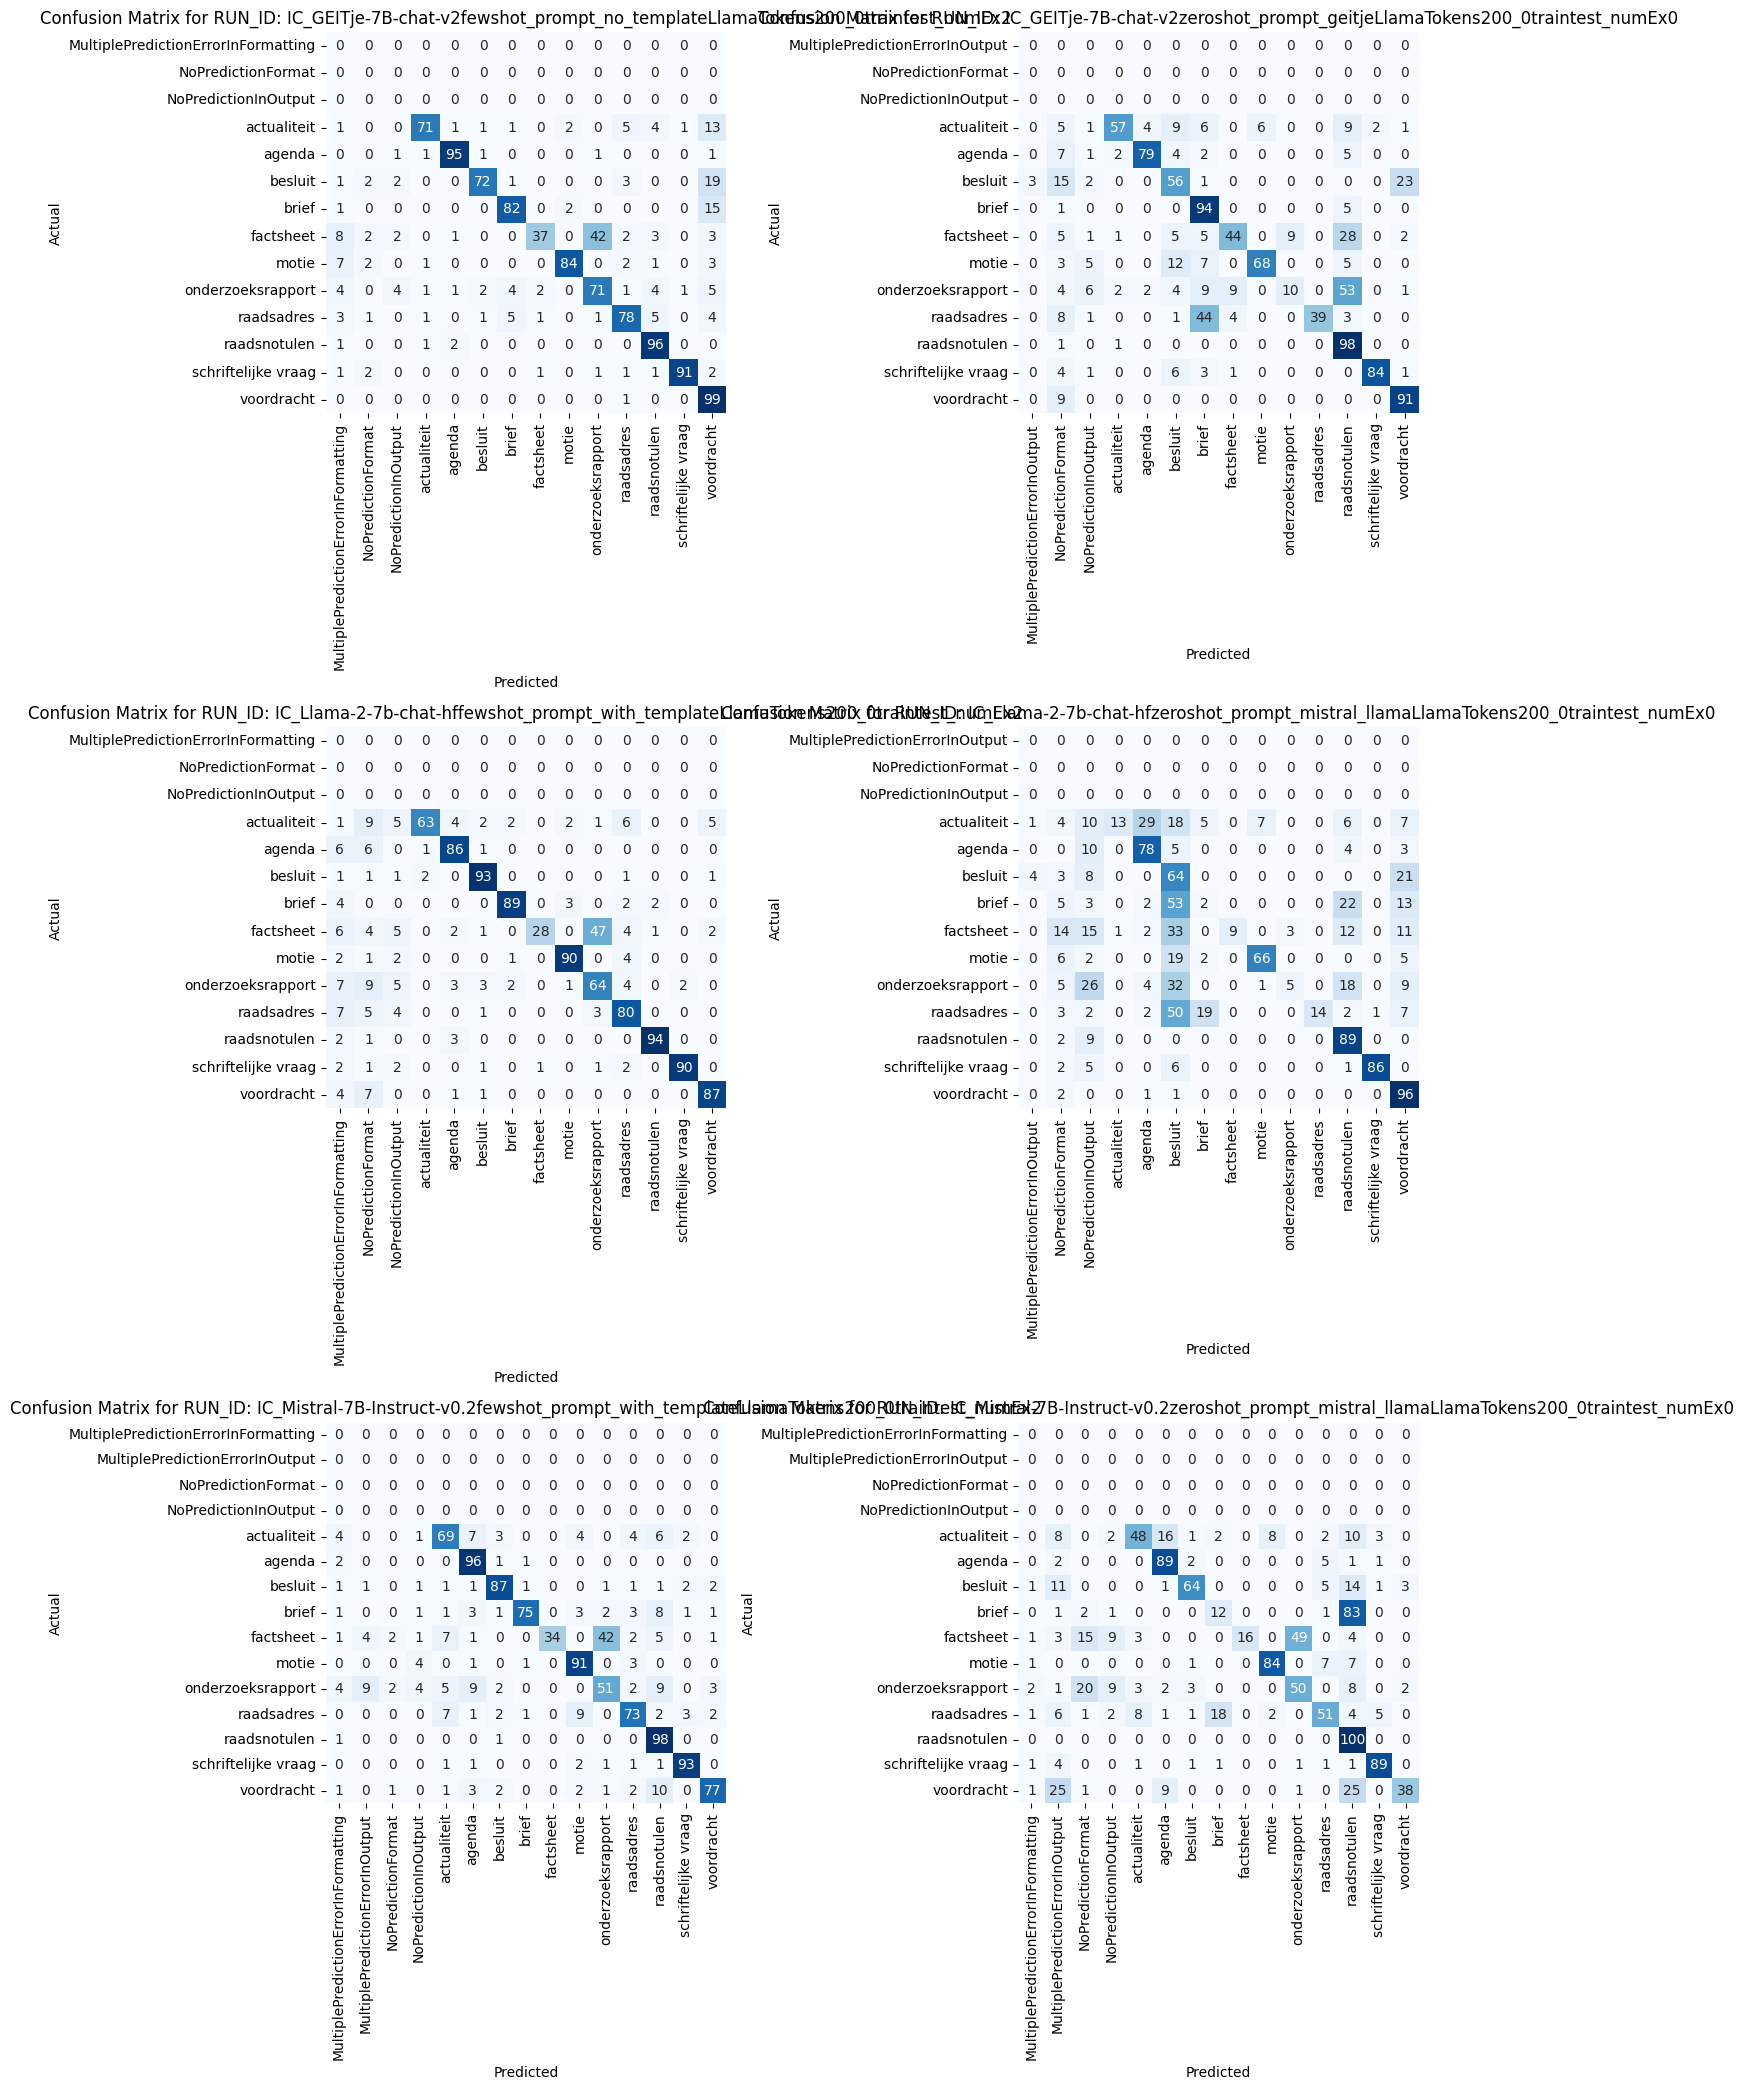

In [12]:
plot_confusion_matrix(combined)